<a href="https://colab.research.google.com/github/rlackdrhkd/Do-it-deep-learning/blob/main/Do_it_%EB%94%A5%EB%9F%AC%EB%8B%9D_8%EC%9E%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np

In [3]:
w = np.array([2,1,5,3])
x = np.array([2,8,3,7,1,2,0,4,5])

In [4]:
w_r = np.flip(w)
print(w_r)

[3 5 1 2]


In [7]:
w_r = w[::-1]
print(w_r)

[3 5 1 2]


In [8]:
for i in range(6):
  print(np.dot(x[i:i+4], w_r))

63
48
49
28
21
20


In [9]:
from scipy.signal import convolve
convolve(x,w,mode='valid')

array([63, 48, 49, 28, 21, 20])

In [10]:
from scipy.signal import correlate
correlate(x,w, mode='valid')

array([48, 57, 24, 25, 16, 39])

In [12]:
correlate(x,w,mode='full')

array([ 6, 34, 51, 48, 57, 24, 25, 16, 39, 29, 13, 10])

In [13]:
correlate(x,w,mode='same')

array([34, 51, 48, 57, 24, 25, 16, 39, 29])

In [15]:
x = np.array([[1,2,3],
             [4,5,6],
             [7,8,9]])
w = np.array([[2,0],[0,0]])
from scipy.signal import correlate2d
correlate2d(x,w,mode='valid')

array([[ 2,  4],
       [ 8, 10]])

In [16]:
correlate2d(x,w,mode='same')

array([[ 2,  4,  6],
       [ 8, 10, 12],
       [14, 16, 18]])

In [17]:
import tensorflow as tf
x_4d = x.astype(np.float).reshape(1,3,3,1)
w_4d = w.astype(np.float).reshape(2,2,1,1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
c_out = tf.nn.conv2d(x_4d,w_4d, strides=1, padding='SAME')

In [19]:
c_out.numpy().reshape(3,3)

array([[ 2.,  4.,  6.],
       [ 8., 10., 12.],
       [14., 16., 18.]])

In [22]:
x = np.array([[1,2,3,4],
              [5,6,7,8],
              [9,10,11,12],
              [13,14,15,16]])
x = x.reshape(1,4,4,1)

In [23]:
p_out = tf.nn.max_pool2d(x,ksize=2,strides=2,padding='VALID')
p_out.numpy().reshape(2,2)

array([[ 6.,  8.],
       [14., 16.]], dtype=float32)

In [24]:
def relu(x):
  return np.maximum(x,0)

In [27]:
x = np.array([-1,2,-3,4,-5])
relu(x)

array([0, 2, 0, 4, 0])

In [28]:
r_out = tf.nn.relu(x)
r_out.numpy()

array([0, 2, 0, 4, 0])

In [50]:
from tensorflow.python.ops.gen_data_flow_ops import accumulator_apply_gradient
from tensorflow.python.ops.nn_ops import softmax_cross_entropy_with_logits
from tensorflow.python.ops.functional_ops import Gradient
from sys import float_repr_style
from numpy.lib.index_tricks import c_
class ConvolutionNetwork:

  def __init__(self, n_kernels=10, units=10, batch_size=32, learning_rate=0.1):
    self.n_kernels = n_kernels
    self.kernel_size =3 
    self.optimizer = None
    self.conv_w = None
    self.conv_b = None
    self.units = units
    self.batch_size = batch_size
    self.w1 = None
    self.b1 = None
    self.w2 = None
    self.b2 = None
    self.a1 = None
    self.losses = []
    self.val_losses = []
    self.lr = learning_rate

  def forpass(self,x):
    c_out = tf.nn.conv2d(x, self.conv_w, strides=1, padding='SAME') + self.conv_b
    r_out = tf.nn.relu(c_out)
    p_put = tf.nn.max_pool2d(r_out, ksize=2, strides=2, padding='VALID')
    f_out = tf.reshape(p_out, [x.shape[0], -1])
    z1 = tf.matmul(f_out, self.w1) + self.b1
    a1 = tf.nn.relu(z1)
    z2 = tf.matmul(a1,self.w2) + self.b2
    return z2

  def init_weights(self, input_shape, n_classes):
    g = tf.initializers.glorot_uniform()
    self.conv_w = tf.Variable(g((3,3,1, self.n_kernels)))
    self.conv_b = tf.Variable(np.zeros(self.n_kernels), dtype=float)
    n_features = 14 * 14 * self.n_kernels
    self.w1 = tf.Variable(g((n_features, self.units)))
    self.b1 = tf.Variable(np.zeros(self.units), dtype=float)
    self.w2 = tf.Variable(g((self.units, n_classes)))
    self.b2 = tf.Variable(np.zeros(n_classes), dtype=float)

  def fit(self,x,y,epochs=100, x_val=None, y_val=None):
    self.init_weights(x.shape,y.shape[1])
    self.optimizer = tf.optimizers.SGD(learning_rate=self.lr)
    for i in range(epochs):
      print('에포크',i,end=' ')
      batch_losses = []
      for x_batch, y_batch in self.gen_batch(x,y):
        print('.',end = '')
        self.training(x_batch,y_batch)
        batch_losses.append(self.get_loss(x_batch, y_batch))
      print()
      self.losses.appen(np.mean(batch_losses))
      self.val_losses.append(self.get_loss(x_val,y_val))

    # 미니배치 제너레이터 함수
  def gen_batch(self, x, y):
    length = len(x)
    bins = length // self.batch_size # 미니배치 횟수
    if length % self.batch_size:
      bins += 1                    # 나누어 떨어지지 않을 때
    indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
    x = x[indexes]
    y = y[indexes]
    for i in range(bins):
      start = self.batch_size * i
      end = self.batch_size * (i + 1)
      yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.
                    
  def training(self,x,y):
    m = len(x)
    with tf.GradientTape() as tape:
      z = self.forpass(x)
      loss = tf.nn.softmax_cross_entropy_with_logits(y,z)
      loss = tf.reduce_mean(loss)

    weights_list = [self.conv_w, self.conv_b,
                    self.w1, self.b1, self.w2, self.b2]

    grads = tape.gradient(loss, weights_list)
    self.optimizer.apply_gradient(zip(grads, weights_list))

  def predict(self,x):
    z = self.forpass(x)
    return np.argmax(z.numpy(), axis=1)

  def score(self,x,y):
    return np.mean(self.predict(x) == np.argmax(y, axis=1))

  def get_loss(self,x,y):
    z = self.forpass(x)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y,z))
    return loss.numpy()

In [52]:
import tensorflow as tf

class ConvolutionNetwork:
    
    def __init__(self, n_kernels=10, units=10, batch_size=32, learning_rate=0.1):
        self.n_kernels = n_kernels  # 합성곱의 커널 개수
        self.kernel_size = 3        # 커널 크기
        self.optimizer = None       # 옵티마이저
        self.conv_w = None          # 합성곱 층의 가중치
        self.conv_b = None          # 합성곱 층의 절편
        self.units = units          # 은닉층의 뉴런 개수
        self.batch_size = batch_size  # 배치 크기
        self.w1 = None              # 은닉층의 가중치
        self.b1 = None              # 은닉층의 절편
        self.w2 = None              # 출력층의 가중치
        self.b2 = None              # 출력층의 절편
        self.a1 = None              # 은닉층의 활성화 출력
        self.losses = []            # 훈련 손실
        self.val_losses = []        # 검증 손실
        self.lr = learning_rate     # 학습률

    def forpass(self, x):
        # 3x3 합성곱 연산을 수행합니다.
        c_out = tf.nn.conv2d(x, self.conv_w, strides=1, padding='SAME') + self.conv_b
        # 렐루 활성화 함수를 적용합니다.
        r_out = tf.nn.relu(c_out)
        # 2x2 최대 풀링을 적용합니다.
        p_out = tf.nn.max_pool2d(r_out, ksize=2, strides=2, padding='VALID')
        # 첫 번째 배치 차원을 제외하고 출력을 일렬로 펼칩니다.
        f_out = tf.reshape(p_out, [x.shape[0], -1])
        z1 = tf.matmul(f_out, self.w1) + self.b1     # 첫 번째 층의 선형 식을 계산합니다
        a1 = tf.nn.relu(z1)                          # 활성화 함수를 적용합니다
        z2 = tf.matmul(a1, self.w2) + self.b2        # 두 번째 층의 선형 식을 계산합니다.
        return z2
    
    def init_weights(self, input_shape, n_classes):
        g = tf.initializers.glorot_uniform()
        self.conv_w = tf.Variable(g((3, 3, 1, self.n_kernels)))
        self.conv_b = tf.Variable(np.zeros(self.n_kernels), dtype=float)
        n_features = 14 * 14 * self.n_kernels
        self.w1 = tf.Variable(g((n_features, self.units)))          # (특성 개수, 은닉층의 크기)
        self.b1 = tf.Variable(np.zeros(self.units), dtype=float)    # 은닉층의 크기
        self.w2 = tf.Variable(g((self.units, n_classes)))           # (은닉층의 크기, 클래스 개수)
        self.b2 = tf.Variable(np.zeros(n_classes), dtype=float)     # 클래스 개수
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.init_weights(x.shape, y.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다.
        self.optimizer = tf.optimizers.SGD(learning_rate=self.lr)
        # epochs만큼 반복합니다.
        for i in range(epochs):
            print('에포크', i, end=' ')
            # 제너레이터 함수에서 반환한 미니배치를 순환합니다.
            batch_losses = []
            for x_batch, y_batch in self.gen_batch(x, y):
                print('.', end='')
                self.training(x_batch, y_batch)
                # 배치 손실을 기록합니다.
                batch_losses.append(self.get_loss(x_batch, y_batch))
            print()
            # 배치 손실 평균내어 훈련 손실 값으로 저장합니다.
            self.losses.append(np.mean(batch_losses))
            # 검증 세트에 대한 손실을 계산합니다.
            self.val_losses.append(self.get_loss(x_val, y_val))

    # 미니배치 제너레이터 함수
    def gen_batch(self, x, y):
        bins = len(x) // self.batch_size                   # 미니배치 횟수
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.
            
    def training(self, x, y):
        m = len(x)                    # 샘플 개수를 저장합니다.
        with tf.GradientTape() as tape:
            z = self.forpass(x)       # 정방향 계산을 수행합니다.
            # 손실을 계산합니다.
            loss = tf.nn.softmax_cross_entropy_with_logits(y, z)
            loss = tf.reduce_mean(loss)

        weights_list = [self.conv_w, self.conv_b,
                        self.w1, self.b1, self.w2, self.b2]
        # 가중치에 대한 그래디언트를 계산합니다.
        grads = tape.gradient(loss, weights_list)
        # 가중치를 업데이트합니다.
        self.optimizer.apply_gradients(zip(grads, weights_list))
   
    def predict(self, x):
        z = self.forpass(x)                 # 정방향 계산을 수행합니다.
        return np.argmax(z.numpy(), axis=1) # 가장 큰 값의 인덱스를 반환합니다.
    
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == np.argmax(y, axis=1))

    def get_loss(self, x, y):
        z = self.forpass(x)                 # 정방향 계산을 수행합니다.
        # 손실을 계산하여 저장합니다.
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, z))
        return loss.numpy()

In [31]:
(x_train_all,y_train_all),(x_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [32]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(x_train_all, y_train_all,
                                               stratify=y_train_all, test_size=0.2,
                                               random_state=42)

In [33]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [34]:
x_train = x_train.reshape(-1,28,28,1)
x_val = x_val.reshape(-1,28,28,1)

In [35]:
x_train.shape

(48000, 28, 28, 1)

In [36]:
x_train = x_train /255
x_val = x_val / 255

In [53]:
cn = ConvolutionNetwork(n_kernels=10, units=100, batch_size=128, learning_rate=0.01)
cn.fit(x_train,y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=20)

에포크 0 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 1 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 2 ......................................................................................................................................................................................................................................

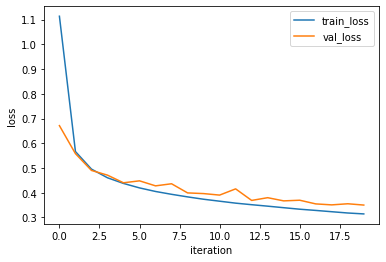

In [55]:
import matplotlib.pyplot as plt

plt.plot(cn.losses)
plt.plot(cn.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss','val_loss'])
plt.show()

In [56]:
cn.score(x_val,y_val_encoded)

0.8776666666666667

In [58]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [59]:
conv1 = tf.keras.Sequential()
conv1.add(Conv2D(10,(3,3), activation='relu', padding='same', input_shape=(28,28,1)))
conv1.add(MaxPooling2D((2,2)))
conv1.add(Flatten())
conv1.add(Dense(100,activation='relu'))
conv1.add(Dense(10,activation='softmax'))

In [60]:
conv1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 10)        100       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 10)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1960)              0         
                                                                 
 dense (Dense)               (None, 100)               196100    
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
__________________________________________________

In [64]:
conv1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [65]:
history = conv1.fit(x_train,y_train_encoded,epochs=20,validation_data=(x_val,y_val_encoded))

Epoch 1/20
1500/1500 [==============================] - 35s 23ms/step - loss: 0.4510 - accuracy: 0.8418 - val_loss: 0.3345 - val_accuracy: 0.8826
Epoch 2/20
1500/1500 [==============================] - 38s 26ms/step - loss: 0.3107 - accuracy: 0.8885 - val_loss: 0.2940 - val_accuracy: 0.8943
Epoch 3/20
1500/1500 [==============================] - 34s 23ms/step - loss: 0.2618 - accuracy: 0.9056 - val_loss: 0.2911 - val_accuracy: 0.8977
Epoch 4/20
1500/1500 [==============================] - 22s 15ms/step - loss: 0.2300 - accuracy: 0.9157 - val_loss: 0.2564 - val_accuracy: 0.9087
Epoch 5/20
1500/1500 [==============================] - 25s 17ms/step - loss: 0.2046 - accuracy: 0.9250 - val_loss: 0.2530 - val_accuracy: 0.9128
Epoch 6/20
1500/1500 [==============================] - 22s 15ms/step - loss: 0.1832 - accuracy: 0.9320 - val_loss: 0.2620 - val_accuracy: 0.9089
Epoch 7/20
1500/1500 [==============================] - 24s 16ms/step - loss: 0.1651 - accuracy: 0.9386 - val_loss: 0.2429 -

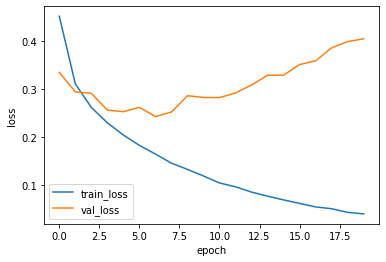

In [66]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

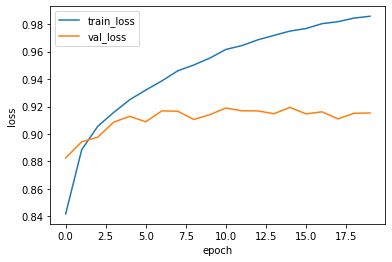

In [67]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

In [71]:
from tensorflow.keras.layers import Dropout

conv2 = tf.keras.Sequential()
conv2.add(Conv2D(10,(3,3), activation='relu', padding='same', input_shape=(28,28,1)))
conv2.add(MaxPooling2D((2,2)))
conv2.add(Flatten())
conv2.add(Dropout(0.5))
conv2.add(Dense(100,activation='relu'))
conv2.add(Dense(10,activation='softmax'))
conv2.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = conv2.fit(x_train,y_train_encoded,epochs=20,validation_data=(x_val,y_val_encoded))

Epoch 1/20
1500/1500 [==============================] - 39s 25ms/step - loss: 0.5335 - accuracy: 0.8061 - val_loss: 0.3768 - val_accuracy: 0.8671
Epoch 2/20
1500/1500 [==============================] - 34s 23ms/step - loss: 0.3901 - accuracy: 0.8586 - val_loss: 0.3161 - val_accuracy: 0.8860
Epoch 3/20
1500/1500 [==============================] - 37s 25ms/step - loss: 0.3451 - accuracy: 0.8736 - val_loss: 0.3049 - val_accuracy: 0.8895
Epoch 4/20
1500/1500 [==============================] - 32s 22ms/step - loss: 0.3134 - accuracy: 0.8852 - val_loss: 0.2796 - val_accuracy: 0.8974
Epoch 5/20
1500/1500 [==============================] - 39s 26ms/step - loss: 0.2936 - accuracy: 0.8932 - val_loss: 0.2711 - val_accuracy: 0.9030
Epoch 6/20
1500/1500 [==============================] - 36s 24ms/step - loss: 0.2801 - accuracy: 0.8954 - val_loss: 0.2645 - val_accuracy: 0.9038
Epoch 7/20
1500/1500 [==============================] - 36s 24ms/step - loss: 0.2639 - accuracy: 0.9006 - val_loss: 0.2485 -

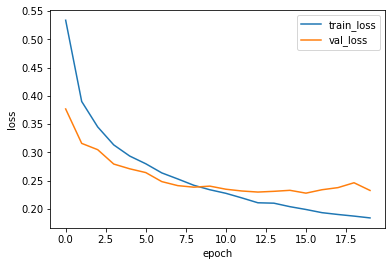

In [75]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

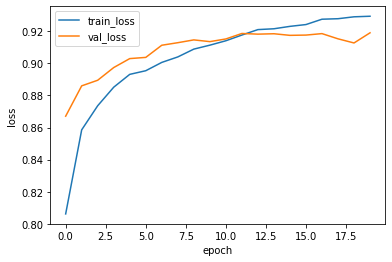

In [76]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()